# Project description
Mobile carrier Megaline has found out that many of their subscribers use legacy plans. They want to develop a model that would analyze subscribers' behavior and recommend one of Megaline's newer plans: Smart or Ultra.

# Description of the data
Every observation in the dataset contains average monthly behavior information about one user. The information given is as follows:

сalls — number of calls,

minutes — total call duration in minutes,

messages — number of text messages,

mb_used — Internet traffic used in MB,

is_ultra — plan for the current month (Ultra - 1, Smart - 0).

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

import warnings
warnings.filterwarnings('ignore')

In [3]:
try:
    data = pd.read_csv('users_behavior (2).csv')
    
except:
    data = pd.read_csv('/datasets/users_behavior.csv')    

# Overview of Data

In [4]:
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [5]:
#checking dtypes 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [6]:
#summary descriptions of our data 
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [7]:
#checking for na Values 
data.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [8]:
#checking for duplicates 
duplicates = data[data.duplicated()]
duplicates

,calls,minutes,messages,mb_used,is_ultra


In [9]:
#outliers in our data set 
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum()
outliers

calls       62
minutes     61
messages    91
mb_used     77
is_ultra     0
dtype: int64

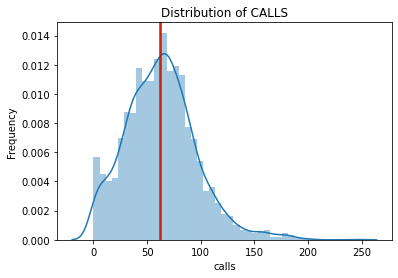

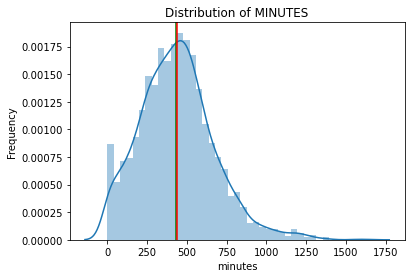

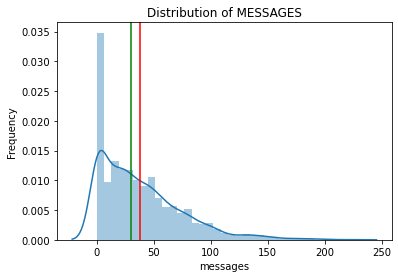

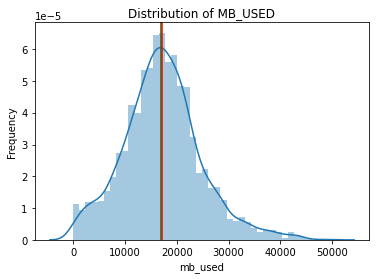

In [12]:
for cols in ['calls','minutes','messages','mb_used']:
    sns.distplot( a=data[cols], hist=True, kde=True )
    plt.axvline(x = data[cols].median(), color='g', linestyle='-', label="Median")
    plt.axvline(x = data[cols].mean(), color='r', linestyle='-', label="Mean")
    plt.title('Distribution of {}'.format(cols.upper()))
    plt.xlabel(cols)
    plt.ylabel("Frequency")
    plt.show()

# Analysis of our Target Variable

0    2229
1     985
Name: is_ultra, dtype: int64

<AxesSubplot:>

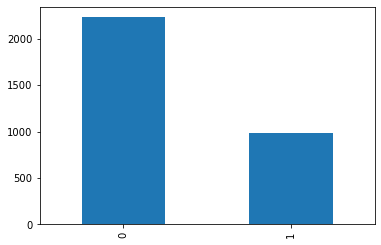

In [13]:
display(data['is_ultra'].value_counts())
data['is_ultra'].value_counts().plot(kind = 'bar')

### We see that our classes are indeed imbalanced: There are  twice as many observations for the "Smart" than for the "Ultra" plan

# Splitting data into train,validation, and test set
Lets split the data set into a 80/20 porpotion. 

In [15]:
X = data.drop('is_ultra', axis=1)
y = data['is_ultra']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state=12345)
#split the data again from X_train and y_train to get a  valid set.
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2,stratify = y_train, random_state=12345)

# Preliminary Accuracy

In [16]:

strategies = ['most_frequent', 'prior']
test_scores = []

for s in strategies:
    dclf = DummyClassifier(strategy = s, random_state = 12345)
    dclf.fit(X_train, y_train)
    score = dclf.score(X_test, y_test)
    test_scores.append(score)
print(test_scores)

[0.6936236391912908, 0.6936236391912908]


In [17]:
#function to print the variable name 
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
#looping over the spilt data to get spilt rows and columns
for part in [X_train, y_train, X_valid, y_valid, X_test, y_test]:
    print(namestr(part, globals())[0], part.shape)

X_train (2056, 4)
y_train (2056,)
X_valid (515, 4)
y_valid (515,)
X_test (643, 4)
y_test (643,)


In [18]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(X_train, y_train)
dec_tree = model.predict(X_valid)
print(f' Our baseline accuracy score for our DecisionTree baseline model is: {accuracy_score(y_valid, dec_tree)}')

 Our baseline accuracy score for our DecisionTree baseline model is: 0.7106796116504854


In [19]:
for depth in range(1, 11):
	model = DecisionTreeClassifier(random_state=12345, max_depth=depth) # create a model with the given depth
	model.fit(X_train, y_train) # train the model
	dec_tree = model.predict(X_valid) # get the model's predictions
	dec_result = round(accuracy_score(y_valid, dec_tree),5) # calculate the accuracy
	print(f'The max_depth {depth}: {dec_result}')

The max_depth 1: 0.75728
The max_depth 2: 0.77282
The max_depth 3: 0.79417
The max_depth 4: 0.79417
The max_depth 5: 0.80777
The max_depth 6: 0.80388
The max_depth 7: 0.80194
The max_depth 8: 0.80194
The max_depth 9: 0.81553
The max_depth 10: 0.78835


In [20]:
decision_tree = DecisionTreeClassifier(random_state=12345, max_depth=6)
decision_tree.fit(X_train, y_train)
pred = decision_tree.predict(X_valid)

acc_tree = round(accuracy_score(y_valid,pred) , 5)
print(f'Our best Decision Tree Model is:{acc_tree}')
              

Our best Decision Tree Model is:0.80388


# Random Forest Classifer 

In [21]:
model = RandomForestClassifier(random_state = 12345)

In [22]:
model.fit(X_train, y_train)
forest_predict = model.predict(X_valid)

In [23]:
print(f' Our baseline accuracy score for our RandomForest model is: {accuracy_score(y_valid, forest_predict)}')

 Our baseline accuracy score for our RandomForest model is: 0.8058252427184466


In [24]:
#creating a list to input parameters . Then incrementing our n_estimator by 10. and Incrementing our max depth by 1
hyper = []

for x in range(1,50,10):
    for depth in range(1,11):
        model = RandomForestClassifier(random_state = 12345, n_estimators = x, max_depth = depth)
        model.fit(X_train, y_train)
        forest_pred = model.predict(X_valid)
        result = round(accuracy_score(y_valid, forest_pred ),5)
        hyper.append({'n_estimators':x , 'max_depth':depth, 'score':result})

In [25]:
#We can see that the max results from dataset  
best = pd.DataFrame(hyper, columns = ['n_estimators','max_depth','score'])
best_para = best[best['score'] == best['score'].max()]
best_para

,n_estimators,max_depth,score
19,11,10,0.8233


In [26]:
model = RandomForestClassifier(random_state = 12345, n_estimators = 11, max_depth = 9)
model.fit(X_train, y_train)
pred = model.predict(X_valid)

rf_acc= round(accuracy_score(y_valid,pred) , 5)
print(f'Our best Random Forest Model is:{rf_acc}')

Our best Random Forest Model is:0.81165


#  LogisticRegression 

In [27]:
model = LogisticRegression(random_state=12345)
model.fit(X_train, y_train)
lr_predict = model.predict(X_valid)
print(f' Our baseline accuracy score for our LogisticRegression model is: {accuracy_score(y_valid, lr_predict)}')

 Our baseline accuracy score for our LogisticRegression model is: 0.7067961165048544


In [28]:
model = LogisticRegression(random_state=12345)
c_values = [ 10, 1.0, 0.1]
           
for z in c_values:
           model = LogisticRegression(random_state=12345, C = z , solver ='lbfgs'  )
           model.fit(X_train, y_train)
           lr_predict = model.predict(X_valid)
           lr_result = round(accuracy_score(y_valid, lr_predict ),5)
           print(f'c_values {z}: {lr_result}')


c_values 10: 0.7068
c_values 1.0: 0.7068
c_values 0.1: 0.74369


In [29]:
LR = LogisticRegression( random_state=12345 )
LR.fit(X_train, y_train)     
y_pred = LR.predict(X_valid)

acc_LR = round(accuracy_score(y_valid,y_pred),5)
print(f' Our best LR model is {acc_LR}')

 Our best LR model is 0.7068


# Our Best Model

In [30]:
data_results = {'DecisionTree':acc_tree *100 , 'RandomForest': rf_acc *100,'LogisticRegression':acc_LR*100}

In [31]:
data_viz = pd.DataFrame(data_results, columns = ['DecisionTree','RandomForest','LogisticRegression'], index=[0])
data_viz.head()

,DecisionTree,RandomForest,LogisticRegression
0,80.388,81.165,70.68


Text(0, 0.5, 'Models')

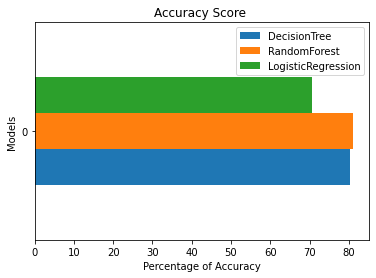

In [32]:
data_viz.plot(kind = 'barh')
plt.title('Accuracy Score ')
plt.xlabel('Percentage of Accuracy')
plt.ylabel('Models')

#### We can see after training all our models Random Forest has best our best with a 80%

# Retraining Our Best Model

In [33]:

rf =RandomForestClassifier(random_state = 12345, n_estimators = 11, max_depth = 9)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

acc_rf = round(accuracy_score(y_test,y_pred) * 100, 5)
acc_rf

81.64852

# Sanity Check
#### The final model was 81.69% a 12.33% higher then our baseline model

# SUMMARY

Our objective for this project was too  develop classification model for Megaline, a mobile carrier, that would analyze subscribers' behavior and recommend one of Megaline's newer plans: Smart or Ultra.
I performed exploratory data analysis  and reach the following conclusions:
There no significant outlier in our dataset, no duplicates in our dataset,
All columns were distributed closely expect for our messages column showing our mean was greater then our median. I left       the column as is
In the next steps I trained and tuned 3 algorithms with the highest accuracy score. I have came to conclusion That Random Forest came out on top with an 80% score. I retrained a Random Forest with the whole training set and came with conclusion with a 81% score. 
